In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

import numpy as np
import torch
from torchvision import transforms, models
from torchinfo import summary
from PIL import Image
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from glob import glob
import timm

### Build DL model

In [ ]:
from utils.helper import get_model

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Load the pre-trained model
model_name = "resnet"
FE = get_model(model_name, num_classes=4, include_top=False)
FE.eval()
## REMOVE LAST CLASSIFIER LAYER
summary(FE, input_size=(1, 3, 224, 224))


### Use DL model to extract features

In [ ]:
def extract_features(image_paths, model, target_size=(224, 224)):
    features = []
    labels = []
    transform = transforms.Compose([
        transforms.Resize(min(target_size)), 
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    with torch.no_grad():
        for img_path, label in image_paths:
            img = Image.open(img_path).convert('RGB')
            img_tensor = transform(img).unsqueeze(0).to(device)
            
            # Extract features
            feature = model(img_tensor)
            
            # Convert to numpy and flatten
            feature = feature.cpu().numpy().flatten()
            feature = feature.flatten() 

            features.append(feature)
            labels.append(label)

    return np.array(features), np.array(labels)

In [ ]:
# versioning dataset
import wandb

run = wandb.init(
    project="hutech_mushroom",
    job_type="train",
)

artifact_data = run.use_artifact('beehappy2554-bosch-global/hutech_mushroom/hutech-dataset:latest', type='dataset')
artifact_data_dir = artifact_data.download()

In [ ]:
data = ["train", "val", "test"]
labels = [0, 1, 2, 3]

# data = ["base"]
# artifact_data_dir = ".."

def load_image_paths(folder, label):
    return [(img_path, label) for img_path in glob(os.path.join(folder, "*.jpg"))]

train_data = []
val_data = []
test_data = []

for l in labels:
    for d in data:
        folder = os.path.join(artifact_data_dir, d, str(l))
        image_paths = load_image_paths(folder, l)
        if d == "train":
            train_data.extend(image_paths)
        elif d == "val":
            val_data.extend(image_paths)
        elif d == "test":
            test_data.extend(image_paths)
        else:
            train_data.extend(image_paths)


print("Processing train data...")
X_train, y_train = extract_features(train_data, FE)
print("Processing validation data...")
X_val, y_val = extract_features(val_data, FE)
print("Processing test data...")
X_test, y_test = extract_features(test_data, FE)

In [ ]:
X_train

# run base model

In [ ]:
C = 1
gamma = "scale"
kernel = "rbf"

model = SVC(C=C, gamma=gamma, kernel=kernel)
# model = SVC(C=0.1, gamma='scale', kernel='linear')
# model = SVC(C=1, gamma="auto", kernel="rbf")
model.fit(X_train, y_train)

## Optimize model

In [ ]:
param_grid = {
    "C": [0.1, 0.5, 1, 2, 10],
    "gamma": ["scale", "auto", 0.1, 1, 5],
    "kernel": ["linear", "rbf"]
}

In [ ]:
from sklearn.model_selection import GridSearchCV
model = SVC()
grid_search = GridSearchCV(model, param_grid, cv=5)     
grid_search.fit(X_train, y_train)

print("Best Params:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

In [ ]:
# try the best model
C = grid_search.best_params_["C"]
gamma = grid_search.best_params_["gamma"]
kernel = grid_search.best_params_["kernel"]

print(C, gamma, kernel)
model = SVC(C=C, gamma=gamma, kernel=kernel)
# model = SVC(C=0.1, gamma='scale', kernel='linear')
# model = SVC(C=1, gamma="auto", kernel="rbf")
model.fit(X_train, y_train)

- val set

In [ ]:
y_pred = model.predict(X_val)

In [ ]:
labels_names = ["nấm mỡ", "nấm bào ngư", "nấm đùi gà", "nấm linh chi trắng"] 

accuracy = accuracy_score(y_val, y_pred)
report = classification_report(y_val, y_pred, target_names=labels_names, zero_division=0)
conf_matrix = confusion_matrix(y_val, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print("\nClassification Report:\n", report)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=labels_names, yticklabels=labels_names)

plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

plt.show()

- test set

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
labels_names = ["nấm mỡ", "nấm bào ngư", "nấm đùi gà", "nấm linh chi trắng"] 

accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, target_names=labels_names, zero_division=0)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print("\nClassification Report:\n", report)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=labels_names, yticklabels=labels_names)

plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

plt.show()

- save model

In [ ]:
import joblib
model_path = "../models"
os.makedirs(model_path, exist_ok=True)
# Save the model
model_path = os.path.join(model_path, "svm_model.pkl")
joblib.dump(model, model_path)

### Inference

In [ ]:
import cv2

def wrapper_model(img_path, feature_extractor, model):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    with torch.no_grad():

        img = Image.open(img_path).convert('RGB')
        img_tensor = transform(img).unsqueeze(0).to(device)
        
        feature = feature_extractor(img_tensor)
        feature = feature.cpu().numpy().flatten()
        feature = feature.flatten() 
        prediction = model.predict(feature.reshape(1, -1))
    
    return prediction.squeeze()

In [ ]:
img_path = os.path.join("../final_test","003.jpg")
labels_names = ["nấm mỡ", "nấm bào ngư", "nấm đùi gà", "nấm linh chi trắng"] 

result = wrapper_model(img_path, FE, model)
print(result)
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.axis("off")
plt.title(labels_names[result])

### Plot test results

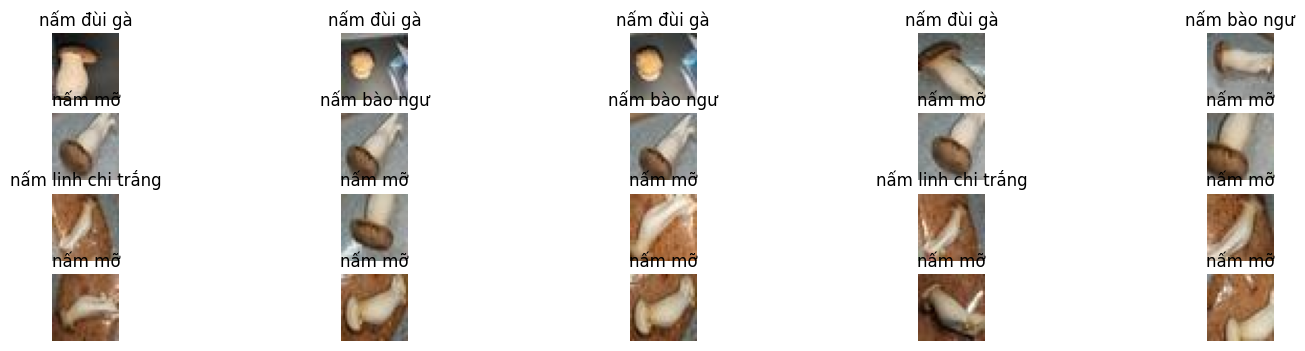

In [40]:
path = "../final_test"

images = glob(os.path.join(path, "*.jpg"))
fig, axes = plt.subplots(4, 5, figsize=(18, 4))
for i, img_path in enumerate(images[50:70]):
    result = wrapper_model(img_path, FE, model)
    result_text = labels_names[result]
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    axes[i // 5, i % 5].imshow(img)
    axes[i // 5, i % 5].axis("off")
    axes[i // 5, i % 5].set_title(result_text)